In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, kstest
from statsmodels.stats.multitest import multipletests

In [6]:
csv_file_path = 'data/data_all_cleaned.csv'
data_raw = pd.read_csv(csv_file_path)

data = data_raw.copy()

print('Cantidad de participantes: ', len(data))
data.head()

Cantidad de participantes:  604


,ext1,ext2,ext3,ext4,ext5,ext6,ext7,ext8,ext9,ext10,...,birth_location_country_clean,age,age_group,openness_score,conscientiousness_score,extraversion_score,agreeableness_score,neuroticism_score,zodiac_sign,zodiac_group
0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,Argentina,25,18-30,48.0,33.0,41.0,42.0,28.0,Leo,Fuego
1,4.0,5.0,3.0,4.0,5.0,5.0,3.0,3.0,2.0,2.0,...,Argentina,26,18-30,50.0,35.0,36.0,44.0,35.0,Aries,Fuego
2,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,...,Spain,23,18-30,42.0,31.0,35.0,31.0,40.0,Acuario,Aire
3,2.0,3.0,4.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0,...,Argentina,56,46-59,36.0,31.0,30.0,42.0,36.0,Capricornio,Tierra
4,3.0,2.0,2.0,3.0,5.0,5.0,5.0,2.0,1.0,1.0,...,Argentina,28,18-30,43.0,33.0,29.0,41.0,20.0,Piscis,Agua


Vamos a probar un simple análisis para ver si estadísticamente las mujeres tienen un score de agreeableness más alto que el de los hombres.

In [7]:
# Separamos los dos grupos
male_agreeableness_scores = data[data['gender'] == 'M']['agreeableness_score']
female_agreeableness_scores = data[data['gender'] == 'F']['agreeableness_score']

# Hacemos un test de normalidad para ver si los datos siguen una distribución normal
male_normality_shapiro = shapiro(male_agreeableness_scores)
female_normality_shapiro = shapiro(female_agreeableness_scores)

print('Male normality', male_normality_shapiro)
print('Female normality', female_normality_shapiro)

male_normality_ks = kstest(male_agreeableness_scores, 'norm')
female_normality_ks = kstest(female_agreeableness_scores, 'norm')

print('Male normality', male_normality_ks)
print('Female normality', female_normality_ks)

Male normality ShapiroResult(statistic=0.9439651370048523, pvalue=3.890101574199889e-09)
Female normality ShapiroResult(statistic=0.9514806270599365, pvalue=1.6082221776514416e-08)
Male normality KstestResult(statistic=1.0, pvalue=0.0, statistic_location=10.0, statistic_sign=-1)
Female normality KstestResult(statistic=1.0, pvalue=0.0, statistic_location=22.0, statistic_sign=-1)


In [8]:
two_extraversion_scores = data[data['happiness_level'] == 5]['extraversion_score']

kstest(two_extraversion_scores, 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=18.0, statistic_sign=-1)

aca en vez de shapiro ver por kolmogorov-smirnov?

En ambos casos los p-values son menores a un alpha de 0.05, lo que sugiere que los scores de agreeableness tanto para hombres como para mujeres no siguen una distribución normal. Usar un t-test, que asume normalidad, no es lo adecuado. En vez de eso vamos a usar un test no-paramétrico que no asume normalidad. El Mann-Whittney U test compara las medianas de los dos grupos independientes y es una buena alternativa al t-test cuando la data no está normalmente distribuida.

In [9]:
u_statistic, p_value = mannwhitneyu(male_agreeableness_scores, female_agreeableness_scores)

print('U statistic', u_statistic)
print('P value', p_value)

U statistic 28814.5
P value 2.3849219280712997e-14


El p-value es mucho menor a un alpha de 0.05, lo que sugiere que hay una diferencia estadísticamente significativa entre los scores de agreeableness de hombres y mujeres.

/var/folders/kx/qk1cp_r506x35p9lld01jtd00000gn/T/ipykernel_65144/2780037775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_and_zodiac_group['is_Aire'] = (scores_and_zodiac_group['zodiac_group'] == 'Aire').astype(int)
/var/folders/kx/qk1cp_r506x35p9lld01jtd00000gn/T/ipykernel_65144/2780037775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_and_zodiac_group['is_Tierra'] = (scores_and_zodiac_group['zodiac_group'] == 'Tierra').astype(int)
/var/folders/kx/qk1cp_r506x35p9lld01jtd00000gn/T/i

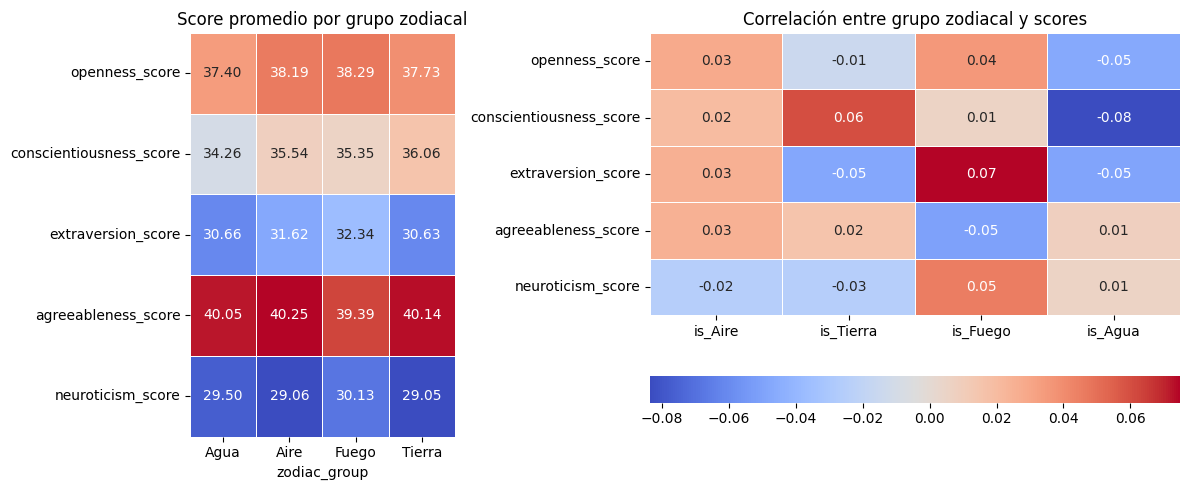

In [10]:
scores_and_zodiac_group = data[['zodiac_group', 'openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']]

# Replace 'gender' with 'zodiac_group' and create dummy variables for each zodiac element
scores_and_zodiac_group['is_Aire'] = (scores_and_zodiac_group['zodiac_group'] == 'Aire').astype(int)
scores_and_zodiac_group['is_Tierra'] = (scores_and_zodiac_group['zodiac_group'] == 'Tierra').astype(int)
scores_and_zodiac_group['is_Fuego'] = (scores_and_zodiac_group['zodiac_group'] == 'Fuego').astype(int)
scores_and_zodiac_group['is_Agua'] = (scores_and_zodiac_group['zodiac_group'] == 'Agua').astype(int)

scores_and_zodiac = scores_and_zodiac_group.drop('zodiac_group', axis=1)

correlation_matrix = scores_and_zodiac.corr()

correlation_with_zodiac_group = correlation_matrix.loc[
    ['is_Aire', 'is_Tierra', 'is_Fuego', 'is_Agua'], 
    ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']
]

mean_scores = data.groupby('zodiac_group')[['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']].mean()

mean_scores = mean_scores.T

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 2]})

# Gráfico 11.1: Scores promedio por género
sns.heatmap(mean_scores, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=ax[0], linewidths=.5)

ax[0].set_title('Score promedio por grupo zodiacal')

# Gráfico 11.2: Correlación entre rasgos de personalidad y género
sns.heatmap(correlation_with_zodiac_group.T, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'orientation': 'horizontal'}, ax=ax[1])
ax[1].set_title('Correlación entre grupo zodiacal y scores')

# Show the plot
plt.tight_layout()
plt.show()

Vamos ahora a comparar el grupo 'Agua' contra los 'No-agua' en la categoría de conscientitud.

In [11]:
water_data = data[data['zodiac_group'] == 'Agua']['conscientiousness_score']
non_water_data = data[data['zodiac_group'] != 'Agua']['conscientiousness_score']

print('Score promedio de Agua', water_data.mean())
print('Score promedio de No Agua', non_water_data.mean())

# Normality tests
normality_water = shapiro(water_data)
normality_non_water = shapiro(non_water_data)

print('Normalidad agua', normality_water)
print('Normalidad no agua', normality_non_water)


Score promedio de Agua 34.25609756097561
Score promedio de No Agua 35.65681818181818
Normalidad agua ShapiroResult(statistic=0.9789925217628479, pvalue=0.013542721047997475)
Normalidad no agua ShapiroResult(statistic=0.9839082360267639, pvalue=8.447805885225534e-05)


De nuevo, en ambos casos el p-value es menor a 0.05, lo cual sugiere que no siguen una distribución normal. Procedemos a realizar un Mann-Whittney U test.

In [12]:
u_statistic, p_value = mannwhitneyu(water_data, non_water_data)

print('U statistic', u_statistic)
print('P value', p_value)

U statistic 32131.0
P value 0.038273731652331396


En este caso, el p-value es menor a un alpha de 0.05, lo cual sugiere que hay una diferencia estadística significativa en la categoría de conscientitud entre los signos de agua (Cáncer, Escorpio y Piscis) y todos los demás signos. 

No es correcto asumir que esto es verdad todavía. Dado que vamos a realizar múltiples comparaciones estadísticas, existe el riesgo de obtener resultados significativos por pura casualidad. Para esto vamos ahora a realizar todos los tests posibles pero aplicando una corrección de Bonferroni, la cual va a dividir el threshold del p-value por la cantidad de tests que realizamos. Este ajuste nos ayuda a ser más rigurosos en nuestra evaluación, asegurándonos de que las diferencias que encontramos no sean simplemente producto del azar.

También vamos a apoyarnos en el método de FDR (False Discovery Rate) que es un poco más flexible. Este método ordena todos los p-values conseguidos de menor a mayor y para cada uno setea el threshold en el alpha de 0.05 multiplicado por (posición)/(cantidad de tests).

In [24]:
def compare_two_groups(data, category, group1, group2, trait):
    group1 = data[data[category] == group1][trait]
    group2 = data[data[category] == group2][trait]

    # Check para ver si hay suficientes datos
    if len(group1) < 3 or len(group2) < 3:
        return {
            'p_value': 1,
            'test_type': 'Insufficient data',
            'group1_size': len(group1),
            'group2_size': len(group2)
        }

    # Normality Test
    normality_group1 = shapiro(group1).pvalue > 0.05
    normality_group2 = shapiro(group2).pvalue > 0.05

    # Statistical Test
    if normality_group1 and normality_group2:
        test_result = ttest_ind(group1, group2)
    else:
        test_result = mannwhitneyu(group1, group2)

    return {
        'group1_mean': round(group1.mean(), 2),
        'group2_mean': round(group2.mean(), 2),
        'group1_size': len(group1),
        'group2_size': len(group2),
        'test_type': 'T-test' if normality_group1 and normality_group2 else 'Mann-Whitney U',
        'p_value': test_result.pvalue
    }

def compare_group_vs_non_group(data, category, group, trait):
    group1 = data[data[category] == group][trait]
    group2 = data[data[category] != group][trait]

    # Check para ver si hay suficientes datos
    if len(group1) < 3 or len(group2) < 3:
        return {
            'p_value': 1,
            'test_type': 'Insufficient data',
            'group1_size': len(group1),
            'group2_size': len(group2)
        }

    # Normality Test
    normality_group1 = shapiro(group1).pvalue > 0.05
    normality_group2 = shapiro(group2).pvalue > 0.05

    # Statistical Test
    if normality_group1 and normality_group2:
        test_result = ttest_ind(group1, group2)
    else:
        test_result = mannwhitneyu(group1, group2)

    return {
        'group1_mean': round(group1.mean(), 2),
        'group2_mean': round(group2.mean(), 2),
        'group1_size': len(group1),
        'group2_size': len(group2),
        'test_type': 'T-test' if normality_group1 and normality_group2 else 'Mann-Whitney U',
        'p_value': test_result.pvalue
    }

def perform_all_group_vs_non_group_comparisons(data, category, trait):
    groups = data[category].unique()
    all_findings = []
    significant_findings = []
    all_p_values = []

    for i in range(len(groups)):
        result = compare_group_vs_non_group(data, category, groups[i], trait)
        all_p_values.append(result['p_value'])
        all_findings.append({
            'category_one': groups[i],
            'category_two': 'Non-' + str(groups[i]),
            'trait': trait,
            'group1_mean': result['group1_mean'] if 'group1_mean' in result else None,
            'group2_mean': result['group2_mean'] if 'group2_mean' in result else None,
            'group1_size': result['group1_size'] if 'group1_size' in result else None,
            'group2_size': result['group2_size'] if 'group2_size' in result else None,
            'p_value': result['p_value'],
            'test_type': result['test_type']
        })

    significant_findings = [result for result in all_findings if result['p_value'] < 0.05]

    # Apply Bonferroni correction
    bonferroni_adjusted = multipletests(all_p_values, method='bonferroni')[0]

    confusion_matrix_bonferroni = {
        'true_positives': sum(bonferroni_adjusted),
        'false_positives': len(significant_findings) - sum(bonferroni_adjusted),
        'true_negatives': len(all_p_values) - len(significant_findings),
        'false_negatives': 0 # Bonferroni correction does not produce false negatives in this context
    }

    # Apply FDR correction
    fdr_adjusted = multipletests(all_p_values, method='fdr_bh')[0]

    confusion_matrix_fdr = {
        'true_positives': sum(fdr_adjusted),
        'false_positives': len(significant_findings) - sum(fdr_adjusted),
        'true_negatives': len(all_p_values) - len(significant_findings),
        'false_negatives': 0 # FDR correction does not produce false negatives in this context
    }

    return {
        'tests_conducted': len(all_findings),
        'significant_findings': significant_findings,
        'bonferroni_findings': [sig for sig, adj in zip(all_findings, bonferroni_adjusted) if adj],
        'confusion_matrix_bonferroni': confusion_matrix_bonferroni,
        'fdr_findings': [sig for sig, adj in zip(all_findings, fdr_adjusted) if adj],
        'confusion_matrix_fdr': confusion_matrix_fdr
    }

def perform_all_group_comparisons(data, category, trait):
    groups = data[category].unique()
    all_findings = []
    significant_findings = []
    all_p_values = []

    for i in range(len(groups)):
        for j in range(i, len(groups)):
            if j == i:
                continue
            result = compare_two_groups(data, category, groups[i], groups[j], trait)
            all_p_values.append(result['p_value'])
            all_findings.append({
                'category_one': groups[i],
                'category_two': groups[j],
                'trait': trait,
                'group1_mean': result['group1_mean'] if 'group1_mean' in result else None,
                'group2_mean': result['group2_mean'] if 'group2_mean' in result else None,
                'group1_size': result['group1_size'] if 'group1_size' in result else None,
                'group2_size': result['group2_size'] if 'group2_size' in result else None,
                'p_value': result['p_value'],
                'test_type': result['test_type']
            })

    significant_findings = [result for result in all_findings if result['p_value'] < 0.05]

    # Apply Bonferroni correction
    bonferroni_adjusted = multipletests(all_p_values, method='bonferroni')[0]

    confusion_matrix_bonferroni = {
        'true_positives': sum(bonferroni_adjusted),
        'false_positives': len(significant_findings) - sum(bonferroni_adjusted),
        'true_negatives': len(all_p_values) - len(significant_findings),
        'false_negatives': 0 # Bonferroni correction does not produce false negatives in this context
    }

    # Apply FDR correction
    fdr_adjusted = multipletests(all_p_values, method='fdr_bh')[0]

    confusion_matrix_fdr = {
        'true_positives': sum(fdr_adjusted),
        'false_positives': len(significant_findings) - sum(fdr_adjusted),
        'true_negatives': len(all_p_values) - len(significant_findings),
        'false_negatives': 0 # FDR correction does not produce false negatives in this context
    }

    return {
        'tests_conducted': len(all_findings),
        'significant_findings': significant_findings,
        'bonferroni_findings': [sig for sig, adj in zip(all_findings, bonferroni_adjusted) if adj],
        'confusion_matrix_bonferroni': confusion_matrix_bonferroni,
        'fdr_findings': [sig for sig, adj in zip(all_findings, fdr_adjusted) if adj],
        'confusion_matrix_fdr': confusion_matrix_fdr
    }

In [27]:
class Colors:
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    FAIL = '\033[91m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    HEADER = '\033[95m'

def perform_analysis(data, category, trait, free_for_all):
    if free_for_all:
        results = perform_all_group_comparisons(data, category, trait)
    else:
        results = perform_all_group_vs_non_group_comparisons(data, category, trait)
    print('---------------------------------')
    print(f'{Colors.HEADER}Categoría analizada: {category} en {trait} {Colors.ENDC}')
    print('---------------------------------')
    print(f'# Tests: ' + str(results['tests_conducted']))
    print(f'Descubrimientos significativos (p-value < 0.05): ' + Colors.WARNING + str(len(results['significant_findings'])) + Colors.ENDC)
    print(f'Aplicando el método Bonferroni: ' + Colors.WARNING + str(len(results['bonferroni_findings'])) + Colors.ENDC)
    # print(f'Matríz de confusión (Bonferroni): ', results['confusion_matrix_bonferroni'])
    # print('---------------------------------')
    # print(f'Descubrimientos significativos por el método de False Discovery Rate: ' + str(len(results['fdr_findings'])))
    # print(f'Matríz de confusión (FDR): ', results['confusion_matrix_fdr'])

    if len(results['bonferroni_findings']) == 0:
        print(Colors.FAIL + 'No se encontraron descubrimientos significativos con el método de Bonferroni.' + Colors.ENDC)
    elif len(results['bonferroni_findings']) > 0:
        print('---------------------------------')
        print(Colors.GREEN + 'Se encontraron descubrimientos significativos con el método de Bonferroni.' + Colors.ENDC)
        for finding in results['bonferroni_findings']:
            higher_group = finding['category_one'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_two']
            lower_group = finding['category_two'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_one']
            print('---------------------------------')
            print(f"{Colors.WARNING}Rasgo: {finding['trait']}{Colors.ENDC}")
            print(f"{finding['category_one']} vs {finding['category_two']}")
            print(f"Media {finding['category_one']}: {finding['group1_mean']:.2f}")
            print(f"Media {finding['category_two']}: {finding['group2_mean']:.2f}")
            print(f"Tamaño de la muestra de {finding['category_one']}: {finding['group1_size']}")
            print(f"Tamaño de la muestra de {finding['category_two']}: {finding['group2_size']}")
            print(f"p-value: {finding['p_value']}")
            print(f"Test type: {finding['test_type']}")
            print(f"Interpretación: {Colors.GREEN}{higher_group} tiene un {finding['trait']} significativamente más alto que {lower_group}.{Colors.ENDC}")

    
    

    # if len(results['fdr_findings']) > 0:
    #     print('---------------------------------')
    #     print('Descubrimientos significativos por el método de False Discovery Rate:')
    #     for finding in results['fdr_findings']:
    #         higher_group = finding['category_one'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_two']
    #         lower_group = finding['category_two'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_one']
    #         print('---------------------------------')
    #         print(f"Rasgo: {finding['trait']}")
    #         print(f"{finding['category_one']} vs {finding['category_two']}")
    #         print(f"Media {finding['category_one']}: {finding['group1_mean']:.2f}")
    #         print(f"Media {finding['category_two']}: {finding['group2_mean']:.2f}")
    #         print(f"p-value: {finding['p_value']}")
    #         print(f"Interpretación: {higher_group} tiene un {finding['trait']} significativamente más alto que {lower_group}.")

   

In [28]:
traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']

In [29]:
for trait in traits:
    perform_analysis(data, 'zodiac_sign', trait, True)

---------------------------------
Categoría analizada: zodiac_sign en openness_score 
---------------------------------
# Tests: 66
Descubrimientos significativos (p-value < 0.05): 3
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en conscientiousness_score 
---------------------------------
# Tests: 66
Descubrimientos significativos (p-value < 0.05): 7
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en extraversion_score 
---------------------------------
# Tests: 66
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en agreeableness_score 
-----------

In [30]:
for trait in traits:
    perform_analysis(data, 'zodiac_sign', trait, False)

---------------------------------
Categoría analizada: zodiac_sign en openness_score 
---------------------------------
# Tests: 12
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en conscientiousness_score 
---------------------------------
# Tests: 12
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en extraversion_score 
---------------------------------
# Tests: 12
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_sign en agreeableness_score 
-----------

In [19]:
for trait in traits:
    perform_analysis(data, 'zodiac_group', trait, True)

---------------------------------
Categoría analizada: zodiac_group en openness_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en conscientiousness_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en extraversion_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en agreeableness_score 
----------

In [31]:
for trait in traits:
    perform_analysis(data, 'zodiac_group', trait, False)

---------------------------------
Categoría analizada: zodiac_group en openness_score 
---------------------------------
# Tests: 4
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en conscientiousness_score 
---------------------------------
# Tests: 4
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en extraversion_score 
---------------------------------
# Tests: 4
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en agreeableness_score 
----------

In [32]:
for trait in traits:
    perform_analysis(data, 'degree_category', trait, True)

---------------------------------
Categoría analizada: degree_category en openness_score 
---------------------------------
# Tests: 36
Descubrimientos significativos (p-value < 0.05): 5
Aplicando el método Bonferroni: 2
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
Business vs Arts
Media Business: 37.10
Media Arts: 40.12
Tamaño de la muestra de Business: 126
Tamaño de la muestra de Arts: 48
p-value: 0.0013881755002003783
Test type: Mann-Whitney U
Interpretación: Arts tiene un openness_score significativamente más alto que Business.
---------------------------------
Rasgo: openness_score
Education vs Arts
Media Education: 36.06
Media Arts: 40.12
Tamaño de la muestra de Education: 34
Tamaño de la muestra de Arts: 48
p-value: 0.000344924463207906
Test type: Mann-Whitney U
Interpretación: Arts tiene un openness_score significativamente más alto que Education.
------------

In [33]:
for trait in traits:
    perform_analysis(data, 'degree_category', trait, False)

---------------------------------
Categoría analizada: degree_category en openness_score 
---------------------------------
# Tests: 9
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 1
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
Arts vs Non-Arts
Media Arts: 40.12
Media Non-Arts: 37.69
Tamaño de la muestra de Arts: 48
Tamaño de la muestra de Non-Arts: 556
p-value: 0.004249260045941319
Test type: Mann-Whitney U
Interpretación: Arts tiene un openness_score significativamente más alto que Non-Arts.
---------------------------------
Categoría analizada: degree_category en conscientiousness_score 
---------------------------------
# Tests: 9
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Cat

In [35]:
for trait in traits:
    perform_analysis(data, 'gender', trait, True)

---------------------------------
Categoría analizada: gender en openness_score 
---------------------------------
# Tests: 3
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 1
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
M vs F
Media M: 38.54
Media F: 37.30
Tamaño de la muestra de M: 294
Tamaño de la muestra de F: 306
p-value: 0.005017946528423955
Test type: Mann-Whitney U
Interpretación: M tiene un openness_score significativamente más alto que F.
---------------------------------
Categoría analizada: gender en conscientiousness_score 
---------------------------------
# Tests: 3
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 1
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: conscientiousness_scor

In [36]:
for trait in traits:
    perform_analysis(data, 'gender', trait, False)

---------------------------------
Categoría analizada: gender en openness_score 
---------------------------------
# Tests: 3
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 2
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
M vs Non-M
Media M: 38.54
Media Non-M: 37.26
Tamaño de la muestra de M: 294
Tamaño de la muestra de Non-M: 310
p-value: 0.0037605653312838146
Test type: Mann-Whitney U
Interpretación: M tiene un openness_score significativamente más alto que Non-M.
---------------------------------
Rasgo: openness_score
F vs Non-F
Media F: 37.30
Media Non-F: 38.48
Tamaño de la muestra de F: 306
Tamaño de la muestra de Non-F: 298
p-value: 0.007171677822198055
Test type: Mann-Whitney U
Interpretación: Non-F tiene un openness_score significativamente más alto que F.
---------------------------------
Categoría analizada: gender en consci

In [37]:
for trait in traits:
    perform_analysis(data, 'age_group', trait, True)

---------------------------------
Categoría analizada: age_group en openness_score 
---------------------------------
# Tests: 10
Descubrimientos significativos (p-value < 0.05): 5
Aplicando el método Bonferroni: 2
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
46-59 vs 31-45
Media 46-59: 36.17
Media 31-45: 39.21
Tamaño de la muestra de 46-59: 107
Tamaño de la muestra de 31-45: 155
p-value: 0.000339019168654417
Test type: Mann-Whitney U
Interpretación: 31-45 tiene un openness_score significativamente más alto que 46-59.
---------------------------------
Rasgo: openness_score
31-45 vs 60+
Media 31-45: 39.21
Media 60+: 35.59
Tamaño de la muestra de 31-45: 155
Tamaño de la muestra de 60+: 32
p-value: 0.004340604203052925
Test type: Mann-Whitney U
Interpretación: 31-45 tiene un openness_score significativamente más alto que 60+.
---------------------------------
Categoría a

In [38]:
for trait in traits:
    perform_analysis(data, 'age_group', trait, False)

---------------------------------
Categoría analizada: age_group en openness_score 
---------------------------------
# Tests: 5
Descubrimientos significativos (p-value < 0.05): 3
Aplicando el método Bonferroni: 2
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
46-59 vs Non-46-59
Media 46-59: 36.17
Media Non-46-59: 38.26
Tamaño de la muestra de 46-59: 107
Tamaño de la muestra de Non-46-59: 497
p-value: 0.0059253351888498606
Test type: Mann-Whitney U
Interpretación: Non-46-59 tiene un openness_score significativamente más alto que 46-59.
---------------------------------
Rasgo: openness_score
31-45 vs Non-31-45
Media 31-45: 39.21
Media Non-31-45: 37.43
Tamaño de la muestra de 31-45: 155
Tamaño de la muestra de Non-31-45: 449
p-value: 0.003425441046763656
Test type: Mann-Whitney U
Interpretación: 31-45 tiene un openness_score significativamente más alto que Non-31-45.
----

In [39]:
for trait in traits:
    perform_analysis(data, 'happiness_level', trait, True)

---------------------------------
Categoría analizada: happiness_level en openness_score 
---------------------------------
# Tests: 10
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: happiness_level en conscientiousness_score 
---------------------------------
# Tests: 10
Descubrimientos significativos (p-value < 0.05): 8
Aplicando el método Bonferroni: 4
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: conscientiousness_score
4 vs 2
Media 4: 36.19
Media 2: 31.32
Tamaño de la muestra de 4: 252
Tamaño de la muestra de 2: 62
p-value: 6.372767117275226e-05
Test type: Mann-Whitney U
Interpretación: 4 tiene un conscientiousness_score significativamente más alto que 2.
---------------------------------
Rasgo: conscientiousne

In [40]:
for trait in traits:
    perform_analysis(data, 'happiness_level', trait, False)

---------------------------------
Categoría analizada: happiness_level en openness_score 
---------------------------------
# Tests: 5
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: happiness_level en conscientiousness_score 
---------------------------------
# Tests: 5
Descubrimientos significativos (p-value < 0.05): 4
Aplicando el método Bonferroni: 2
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: conscientiousness_score
5 vs Non-5
Media 5: 37.86
Media Non-5: 34.90
Tamaño de la muestra de 5: 77
Tamaño de la muestra de Non-5: 527
p-value: 0.000804029937999215
Test type: Mann-Whitney U
Interpretación: 5 tiene un conscientiousness_score significativamente más alto que Non-5.
---------------------------------
Rasgo: co

to detect bullshit look at the graphs not the metrics

                         happiness_level  openness_score  \
happiness_level                 1.000000        0.045498   
openness_score                  0.045498        1.000000   
conscientiousness_score         0.243549        0.104080   
extraversion_score              0.293952        0.261124   
agreeableness_score             0.235524        0.213602   
neuroticism_score              -0.406137       -0.057712   

                         conscientiousness_score  extraversion_score  \
happiness_level                         0.243549            0.293952   
openness_score                          0.104080            0.261124   
conscientiousness_score                 1.000000            0.071583   
extraversion_score                      0.071583            1.000000   
agreeableness_score                     0.247713            0.298894   
neuroticism_score                      -0.241598           -0.233865   

                         agreeableness_score  neuroticism_score  
happines

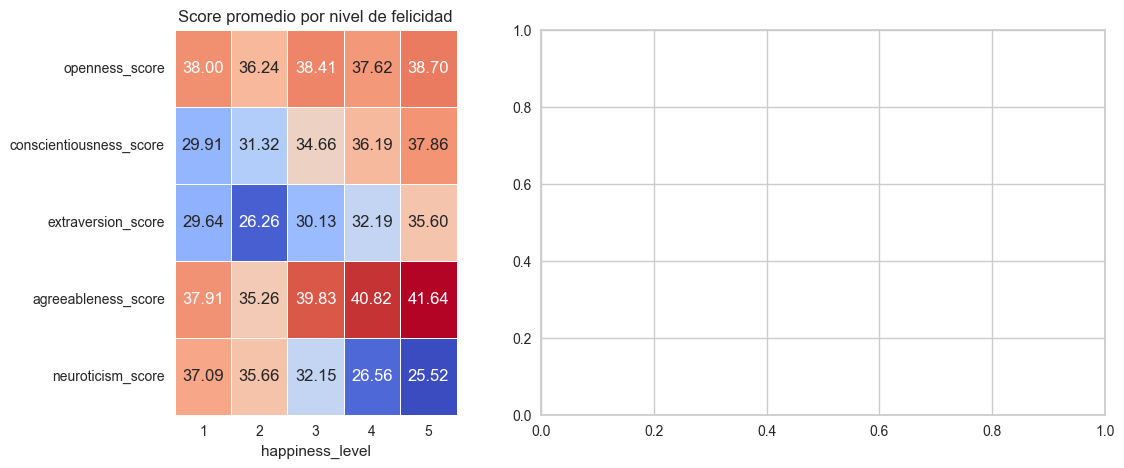

In [ ]:
mean_scores = data.groupby('happiness_level')[['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']].mean()

mean_scores = mean_scores.T

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 2]})

sns.heatmap(mean_scores, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=ax[0], linewidths=.5)

ax[0].set_title('Score promedio por nivel de felicidad')

scores_and_happiness = data[['happiness_level', 'openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']]

correlation_matrix = scores_and_happiness.corr()

print(correlation_matrix)

# correlation_with_happiness = correlation_matrix.loc[['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score'], 
#     ['happiness_level', 'openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']
# ]

# sns.heatmap(correlation_with_happiness.T, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'orientation': 'horizontal'}, ax=ax[1])
# ax[1].set_title('Correlación entre nivel de felicidad y rasgo de personalidad')

# plt.tight_layout()
# plt.show()

In [ ]:
traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score', 'happiness_level']

# Calculating the correlation matrix
correlation_matrix = data[traits].corr()

# Extracting the correlation with 'happiness_level'
happiness_correlations = correlation_matrix.loc['happiness_level'].drop('happiness_level')

# Displaying the correlation coefficients between 'happiness_level' and each trait
print(happiness_correlations)

openness_score             0.045498
conscientiousness_score    0.243549
extraversion_score         0.293952
agreeableness_score        0.235524
neuroticism_score         -0.406137
Name: happiness_level, dtype: float64


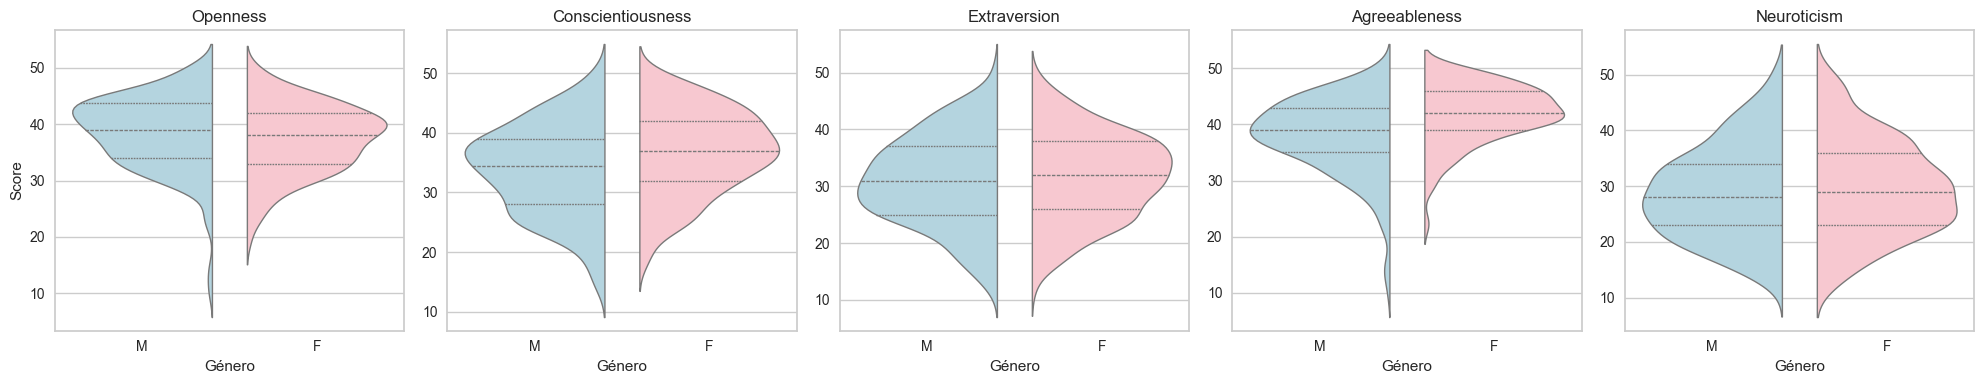

In [ ]:
traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']
trait_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

# Gráfico: Violin plots de cada OCEAN trait por género
plt.figure(figsize=(20, 4))

for i, (trait, trait_name) in enumerate(zip(traits, trait_names)):
    plt.subplot(1, 5, i+1)
    sns.violinplot(data=data[data['gender'].isin(['M', 'F'])], x='gender', y=trait, split=True, palette=['lightblue', 'pink'], linewidth=1, hue='gender', inner='quartile')
    plt.title(trait_name)
    plt.xlabel('Género')
    plt.ylabel('Score')
    if i > 0:
        plt.ylabel('')

plt.tight_layout()
plt.show()

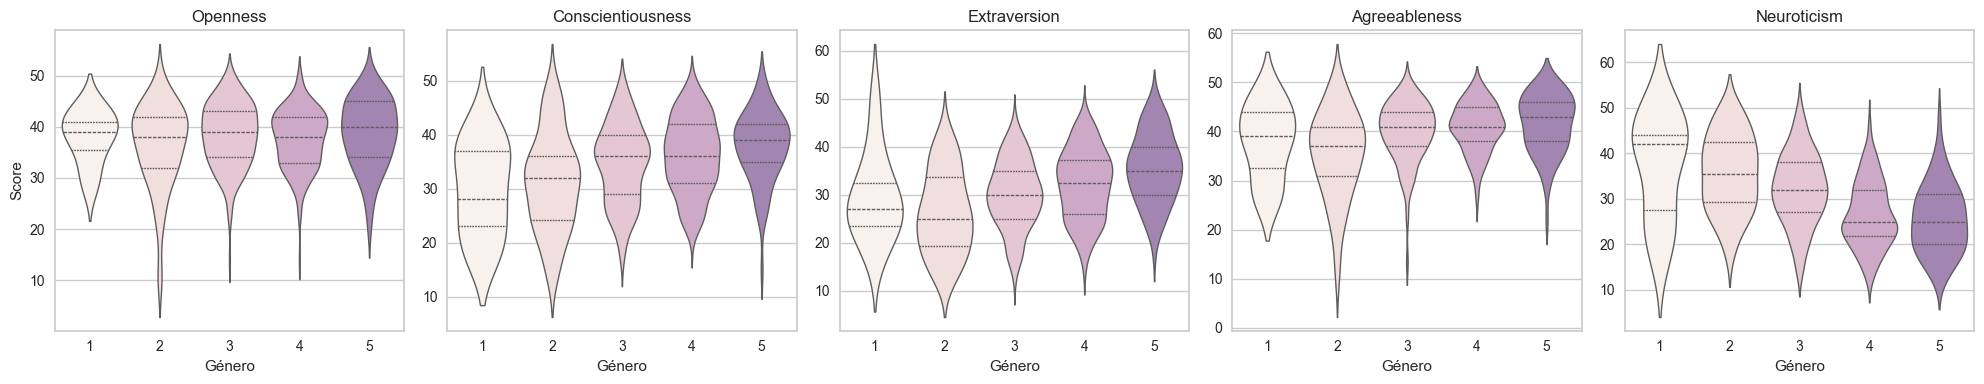

In [ ]:
traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']
trait_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

# Gráfico: Violin plots de cada OCEAN trait por happiness level
plt.figure(figsize=(20, 4))

for i, (trait, trait_name) in enumerate(zip(traits, trait_names)):
    plt.subplot(1, 5, i+1)
    sns.violinplot(data=data, x='happiness_level', y=trait, linewidth=1, inner='quartile', hue='happiness_level', palette=sns.cubehelix_palette(5, start=.1, gamma=0.3), legend=False)
    plt.title(trait_name)
    plt.xlabel('Género')
    plt.ylabel('Score')
    if i > 0:
        plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
data['happiness_level'].value_counts()

happiness_level
4    252
3    202
5     77
2     62
1     11
Name: count, dtype: int64

In [ ]:
data.sample(5)

,ext1,ext2,ext3,ext4,ext5,...,zodiac_group,is_Aire,is_Tierra,is_Fuego,is_Agua
595,3.0,3.0,3.0,2.0,4.0,...,Aire,1,0,0,0
251,2.0,2.0,2.0,3.0,3.0,...,Aire,1,0,0,0
31,2.0,3.0,2.0,2.0,2.0,...,Tierra,0,1,0,0
515,1.0,1.0,3.0,2.0,2.0,...,Agua,0,0,0,1
228,4.0,5.0,4.0,2.0,4.0,...,Tierra,0,1,0,0
